NOTE: This code was built in 11.3.1

In [50]:
import os 
import glob
import numpy as np
import pdfplumber
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.cluster import KMeans
import openpyxl

## PART I: SOURCING THE FILES 

To prevent any possible information being shared files are kept at a different location and the file paths will be kept under .gitignore and only read from the variable paths but never displayed. Also in the future all seeds and some functions will be kept like that.

In [51]:
#read paths from paths.txt
with open('paths.txt') as f:
    paths = f.readlines()

In [52]:
#Import the data 
folder_path = paths[0].strip()
pdf_files = []

# Iterate over PDF files in the folder to get file names over which we can iterate
for file_path in glob.glob(folder_path + "*.pdf"):
    # Extract the file name from the file path
    file_name = file_path.split("/")[-1]
    
    # Add the file name and creation time to the list
    pdf_files.append(file_name)

# Print the list of PDF file names and their creation dates
#print(pdf_files)


## PART II: EXTRACTING DATA FROM THE SOURCE FILES 

Now that we have the file names we need to build a function that will be able the convert the pdfs to pd.DataFrame-s 

In [53]:
def process_invoices(pdf_files, brand_names, extra_quantity_marker,file_path=folder_path):
    """
    Extracts item quantities and prices from invoices and do initial processing to pd.DataFrame.
    Some of the debugging print statements are commented out.
    """
    initial_wd = os.getcwd()
    os.chdir(file_path)
    df_pd = pd.DataFrame()
    df_total = pd.DataFrame()
    df_quantity = pd.DataFrame()

    num_of_errors=0
    for file in pdf_files:
        #print(f"Processing: {file}.")
        with pdfplumber.open(file) as pdf:
            # Find the invoice date
            text = pdf.pages[0].extract_text()
            #print(f"Processing date...")
            date_line = [line for line in text.split('\n') if 'Afleverdatum' in line]
            if not date_line:
                print(f"No invoice date found in {file}")
                continue
            date_str = date_line[0].split()[-1]
            invoice_date = datetime.strptime(date_str, '%d-%m-%Y').date()

            #Process the rest of the invoice
            for i in range(len(pdf.pages)): 
                #print(f"Processing page {i+1} of {len(pdf.pages)}")
                text = pdf.pages[i].extract_text()

                # Find the table with item prices
                table_start = [i for i, line in enumerate(text.split('\n')) if 'artikel aantal be inhoud eh colli merk artikelomschrijving inhoud adviesprijs' in line]
                if not table_start:
                    #print(f"No item table found in {file}")
                    continue
                table_start = table_start[0]
                
                # Extract item information, quantity, and prices
                items = []
                quantities = []
                prices = []
                ppqs = []
                total_paid = None
                lines = text.split('\n')[table_start+1:]
                for line in lines:
                    if not line.strip():
                        break
                    parts = line.split()
                    if len(parts) < 4:
                        continue  # Skip lines without enough categories
                    
                    # Find the brand name
                    brand_name = None
                    for brand in brand_names:
                        if brand in line:
                            brand_name = brand
                            break
                    if not brand_name:
                        continue
                    
                    # Extract the product name between the brand name and the last two parts
                    product_parts = parts[parts.index(brand_name) + 1:-2]   
                    item = ' '.join(product_parts)
                    quantity = parts[1].replace(',', '.')

                    if parts[4] in extra_quantity_marker:
                        quantity = float(parts[1].replace(',','.'))*float(parts[3].replace(',', '.'))
                    
                    # This is corner case for some dates
                    if parts[1]==str('B'): 
                        quantity = parts[2].replace(',', '.')
                    
                    price = parts[-1].replace(',', '.')

                    try:
                        ppq= round(float(price)/float(quantity),2)
                    except ValueError:
                        break

                    if parts[2]=='KG':
                        # kg chnages the interpretation of the price per quantity
                        quantity = float(parts[1].replace(',','.'))
                        ppq=round(float(price)/quantity,2)

                    try:
                        price = float(price)
                        items.append(item)
                        quantities.append(quantity)
                        prices.append(price)
                        ppqs.append(ppq)
                    except ValueError:
                        print(f"Skipping line: {line}")
                
                try:
                    eval_var= round(float(price)/float(quantity),2)
                except ValueError:
                    num_of_errors+=1
                    #print(f"No prices. Check {file}")
                    break

                # Find the total price
                total_line = [line for line in text.split('\n') if 'Totaal' in line]
                if not total_line:
                    #print(f"No total price found in {file}")
                    continue
                elif len(total_line[0].split())>1:
                    total_line = total_line[0].split()
                    total_paid = float(total_line[-1].replace(',', '.'))
                    
                # Create a DataFrame for item prices over time
                data = {'Date': [invoice_date] * len(items), 'Item': items, 'Quantity': quantities, 'Price': prices, 'PPQ': ppqs}
                df = pd.DataFrame(data)
                df_pd=pd.concat([df_pd, df],ignore_index=True,axis=0)

                #Create a DataFrame for quantity over time
                df_quantity_add = pd.DataFrame({'Date': [invoice_date] * len(items), 'Item': items, 'Quantity': quantities})
                df_quantity=pd.concat([df_quantity, df_quantity_add],ignore_index=True,axis=0)

                # Add the total price to the DataFrame
                df_total_add = pd.DataFrame({'Date': [invoice_date], 'Total price': [total_paid]})
                df_total=pd.concat([df_total, df_total_add],ignore_index=True,axis=0)
        
        
        #print(f"Succesfully processed {file}")

    #print(f"Number of errors: {num_of_errors}")
    #print(f"Number of invoices processed: {len(pdf_files)-num_of_errors}")
    #print(f"Success rate: {round((len(pdf_files)-num_of_errors)/len(pdf_files)*100,2)}%"")
    df_total=df_total.dropna()
 
    #put the working directory back to the original
    os.chdir(initial_wd)  

    return df_pd, df_total, df_quantity  
    

            


In [54]:
#Import brand names and extra quantity markers from hidden files
brand_names = pd.read_csv('brand_names.csv', header=None).iloc[0].tolist()
extra_quantity_marker= pd.read_csv('extra_quantity_marker.csv', header=None).iloc[0].tolist()

In [55]:
df, df_total, df_quantity=process_invoices(pdf_files, brand_names,extra_quantity_marker)

In [56]:
# To hide item names change them to "Item0001", "Item0002", etc.
def rename_items(items):
    """
    Function to rename items to "Item0001", "Item0002", etc. taking into 
    account the order of appearance of the items in the list and multiple entries
    of the same item.
    """
    unique_items = pd.Series(items).unique()
    mapping = {item: f'Item{i:03}' for i, item in enumerate(unique_items, 1)}
    return items.map(mapping)

df['Item'] = rename_items(df['Item'])
df_quantity['Item'] = rename_items(df_quantity['Item'])


## PARTS III AND IV: FILTERING, ANALYSING AND MAKING VISUALISATIONS OF THE DATA

(If you ask me just skip questions 1 and 2 as they are not important imo to begin with. Question 3 has the best insights and is just a better question to ask.)

In [57]:
# Group by "Item" and calculate the average price per item
df=pd.DataFrame(df)
df_pivot = df.reset_index().pivot_table(index='Item', columns='Date', values='PPQ')

In [58]:
#change directory to files folder so that also excel outputs will be saved there 
#os.chdir(folder_path) 

#Export excel files, so that others can read them
#df_pivot.to_excel('df_pivot.xlsx', index=True)
#df_total.sort_values("Date").to_excel('df_total.xlsx', index=True)

## QUESTION 1: Which items have increased the most in price?

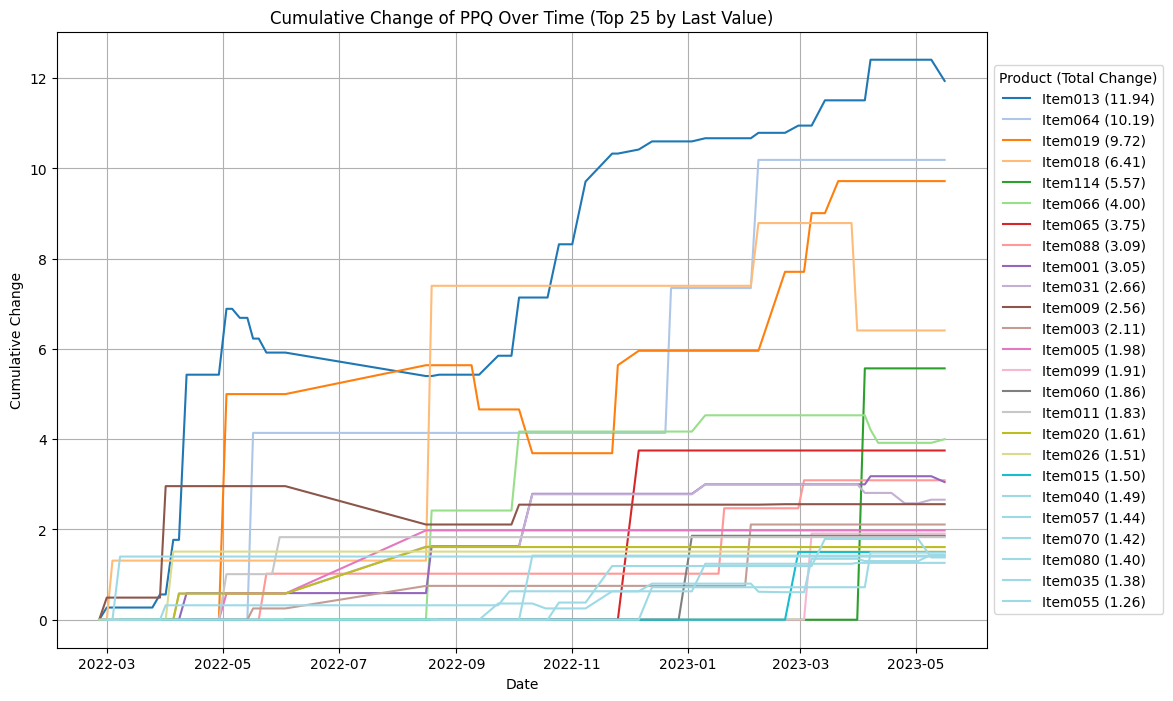

In [73]:
## TOP 25

# Calculate the cumulative change for each item
df_cum_change = df_pivot.ffill(axis=1).diff(axis=1).cumsum(axis=1)
df_cum_change = df_cum_change.loc[df_cum_change.abs().sum(axis=1) != 0]

# Get the last non NaN value for each item
last_values = df_cum_change.iloc[:, -1].dropna()

# Select the top 15 items with the biggest changes
top_15_items = last_values.nlargest(25).index

# Select only the top 15 items for plotting
df_top_15_cum_changes = df_cum_change.loc[top_15_items]
#df_top_15_cum_changes.to_excel('top_25_cum_changes.xlsx',index=True)

fig, ax = plt.subplots(figsize=(12, 8))
final_changes = []

# Define colors for lines and legend entries
colors = plt.cm.tab20(range(len(df_top_15_cum_changes.index)))

for idx, item in enumerate(df_top_15_cum_changes.index):
    line_color = colors[idx]
    line, = ax.plot(df_top_15_cum_changes.columns, df_top_15_cum_changes.loc[item], color=line_color)
    final_change = last_values.loc[item]
    final_changes.append(final_change)
    line.set_label(f"{item} ({final_change:.2f})")

# Sort the legend labels by final changes
legend_labels = [line.get_label() for line in ax.lines]
sorted_lines = [line for _, line in sorted(zip(final_changes, ax.lines), key=lambda x: x[0], reverse=True)]
sorted_legend_labels = [label for _, label in sorted(zip(final_changes, legend_labels), key=lambda x: x[0], reverse=True)]

# Create a separate legend with sorted labels and final changes
plt.legend(sorted_lines, sorted_legend_labels, loc='center left', bbox_to_anchor=(1, 0.5), title='Product (Total Change)')

ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Change')
ax.set_title('Cumulative Change of PPQ Over Time (Top 25 by Last Value)')
ax.grid(True)

plt.show()

I am adding a feauture that was later requested: only plot a couple of items they want

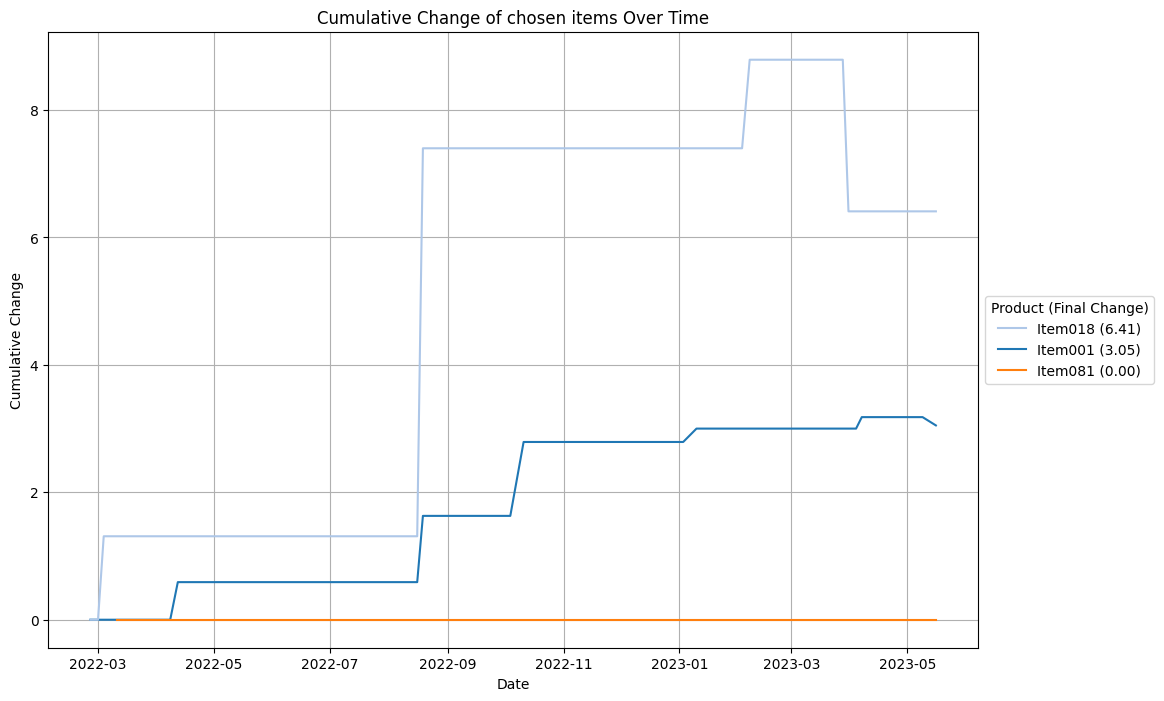

In [80]:
## CHOOSE ITEMS
items_choose=['Item001','Item018','Item081']
df_chosen_items = df_pivot.loc[items_choose]

# Calculate the cumulative change for each item
df_cum_change = df_chosen_items.ffill(axis=1).diff(axis=1).cumsum(axis=1)

# Select the top 15 items with the biggest cumulative changes
top_15_cum_changes = df_cum_change.abs().sum(axis=1).index
#top_15_cum_changes = top_15_cum_changes.drop("MUESLI FRUIT-NOTEN")
df_top_15_cum_changes = df_cum_change.loc[top_15_cum_changes]
fig, ax = plt.subplots(figsize=(12, 8))
final_changes = []


# Define colors for lines and legend entries
colors = plt.cm.tab20(range(len(df_top_15_cum_changes.index)))

for idx, item in enumerate(df_top_15_cum_changes.index):
    line_color = colors[idx]
    line, = ax.plot(df_top_15_cum_changes.columns, df_top_15_cum_changes.loc[item], color=line_color)
    final_change = df_top_15_cum_changes.loc[item].iloc[-1]
    final_changes.append(final_change)
    line.set_label(f"{item} ({final_change:.2f})")

# Sort the legend labels by final changes
legend_labels = [line.get_label() for line in ax.lines]
sorted_legend_labels = [label for _, label in sorted(zip(final_changes, legend_labels), reverse=True)]
sorted_lines = [line for _, line in sorted(zip(final_changes, ax.lines), reverse=True)]

# Create a separate legend with sorted labels and final changes
plt.legend(handles=sorted_lines, labels=sorted_legend_labels, loc='center left', bbox_to_anchor=(1, 0.5), title='Product (Final Change)')

ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Change')
ax.set_title('Cumulative Change of chosen items Over Time')
ax.grid(True)

plt.show()


## QUESTION 2: How much has the total price of the invoices risen?

The following is the analysis of how the total changes over time and if there is a significant change. In the first graph we would notice by visual inspection that there is an obvious separation in the data between large and smaller bills. (It would later turn out that there really are two types of orders which are on the same invoice but need to be separated). I used both k-means clustering and visual inspection.

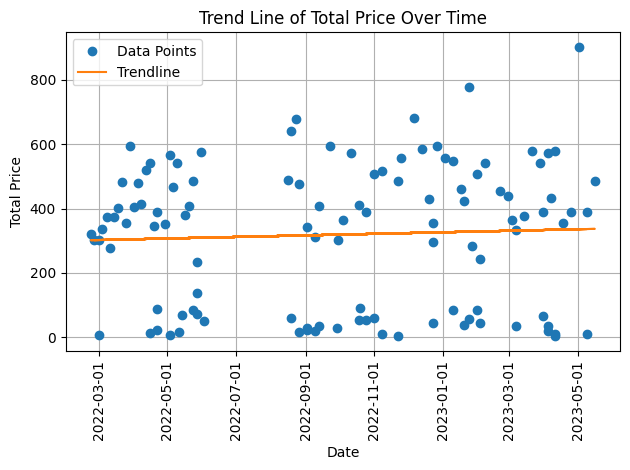

In [65]:
# Assuming your DataFrame has a 'date' column and a 'total_price' column
x = df_total['Date']
y = df_total['Total price']

# Fit a polynomial of degree 1 (linear regression)
coefficients = np.polyfit(mdates.date2num(x), y, deg=1)
trendline = np.polyval(coefficients, mdates.date2num(x))

# Plot the data points and the trendline
plt.plot(x, y, 'o', label='Data Points')
plt.plot(x, trendline, label='Trendline')

# Format x-axis ticks as dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

plt.xlabel('Date')
plt.ylabel('Total Price')
plt.title('Trend Line of Total Price Over Time')
plt.grid(True)
plt.legend()
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()


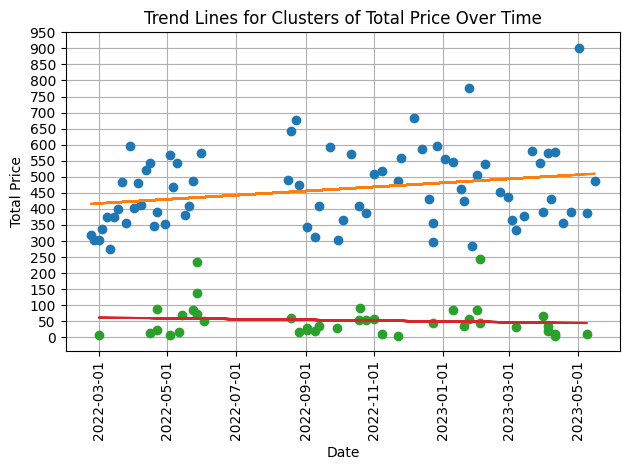

In [86]:
# Assuming your DataFrame has a 'date' column and a 'total_price' column
x = df_total['Date']
y = df_total['Total price']

# Convert date values to numeric format
x_numeric = mdates.date2num(x)

# Perform K-means clustering
kmeans = KMeans(n_clusters=2, n_init=10)
kmeans.fit(y.values.reshape(-1, 1))
cluster_labels = kmeans.labels_

# Plot the data points and the trend lines for each cluster
for cluster_id in np.unique(cluster_labels):
    cluster_mask = cluster_labels == cluster_id
    x_cluster = x[cluster_mask]
    x_numeric_cluster = x_numeric[cluster_mask]
    y_cluster = y[cluster_mask]

    # Fit a polynomial of degree 1 (linear regression) for each cluster
    coefficients = np.polyfit(x_numeric_cluster, y_cluster, deg=1)
    trendline = np.polyval(coefficients, x_numeric_cluster)

    # Plot the data points and the trend line for the cluster
    plt.plot(x_cluster, y_cluster, 'o', label=f'Cluster {cluster_id} Data Points')
    plt.plot(x_cluster, trendline, label=f'Cluster {cluster_id} Trendline')

# Format x-axis ticks as dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

plt.xlabel('Date')
plt.ylabel('Total Price')
plt.title('Trend Lines for Clusters of Total Price Over Time')
plt.grid(True)
plt.xticks(rotation=90)
plt.yticks(np.arange(0, 1000, 50))
plt.tight_layout()
plt.show()


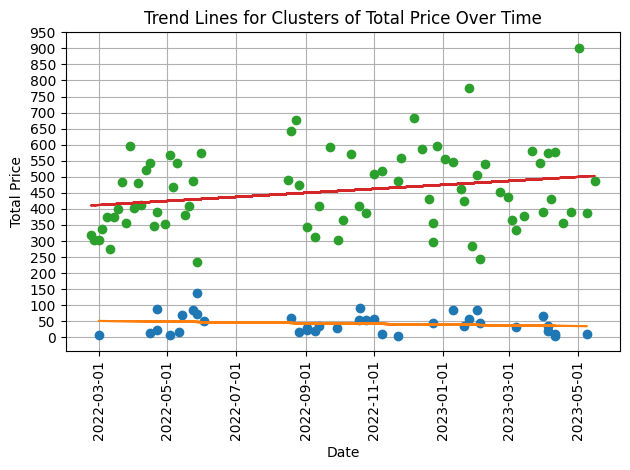

In [67]:

# Assuming your DataFrame has a 'date' column and a 'total_price' column
x = df_total['Date']
y = df_total['Total price']

# Convert date values to numeric format
x_numeric = mdates.date2num(x)

# Split the data based on the threshold of 100 EUR
threshold = 150
below_threshold_mask = y < threshold
above_threshold_mask = y >= threshold

x_below = x[below_threshold_mask]
x_numeric_below = x_numeric[below_threshold_mask]
y_below = y[below_threshold_mask]

x_above = x[above_threshold_mask]
x_numeric_above = x_numeric[above_threshold_mask]
y_above = y[above_threshold_mask]

# Fit a polynomial of degree 1 (linear regression) for each cluster
coefficients_below = np.polyfit(x_numeric_below, y_below, deg=1)
trendline_below = np.polyval(coefficients_below, x_numeric_below)

coefficients_above = np.polyfit(x_numeric_above, y_above, deg=1)
trendline_above = np.polyval(coefficients_above, x_numeric_above)

# Plot the data points and the trend lines for each cluster
plt.plot(x_below, y_below, 'o', label='Below 100 EUR Data Points')
plt.plot(x_below, trendline_below, label='Below 100 EUR Trendline')

plt.plot(x_above, y_above, 'o', label='Above 100 EUR Data Points')
plt.plot(x_above, trendline_above, label='Above 100 EUR Trendline')

# Format x-axis ticks as dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

plt.xlabel('Date')
plt.ylabel('Total Price')
plt.title('Trend Lines for Clusters of Total Price Over Time')
plt.grid(True)
plt.xticks(rotation=90)
plt.yticks(np.arange(0, 1000, 50))
plt.tight_layout()
plt.show()


## QUESTION 3:  Which items' price increase has contributed the most to the specific orders of the hotel?


Now for the final part of this notebook I will answer my own question of which price increases contributed the most. Arguably there are many ways to do this, but the way I did it is to multiply the changes in price per the quantity ordered as they occur (i.e. if eggs increased with 1 EUR by 6 June but 10 EUR by today, the values before 6 June will be multiplied by 1 not 10)
and then do a ordered bar chart to visualise it.

In [82]:
df_quantity_pivot = df.reset_index().pivot_table(index='Item', columns='Date', values='Quantity').fillna(0)
#df_quantity_pivot.to_excel('quantity_pivot.xlsx',index=True)
df_cum_change = df_pivot.ffill(axis=1).diff(axis=1).cumsum(axis=1).fillna(0)
df_cum_change_impact = pd.DataFrame(df_cum_change.values * df_quantity_pivot.values, columns=df_cum_change.columns, index=df_cum_change.index)
df_cum_change_weighted = df_cum_change_impact.sum(axis=1).sort_values(ascending=False)[:127]

In [83]:
overall_impact = df_cum_change_weighted.sum()
df_cum_change_weighted_pct = df_cum_change_weighted / overall_impact

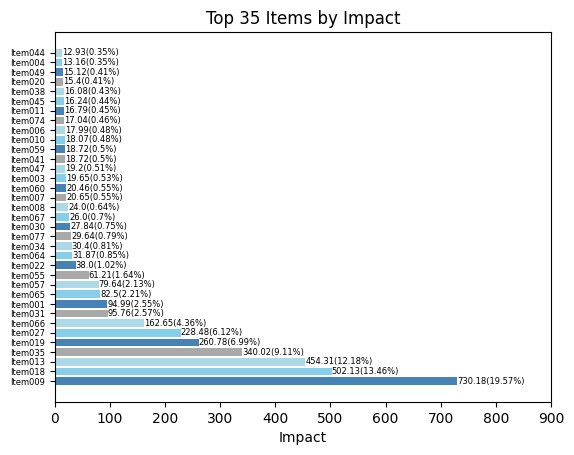

In [85]:
# Select top 15 items
top_15 = df_cum_change_weighted.head(35)

# Create a figure and axis
fig, ax = plt.subplots()

# Create a bar plot with different colors
colors = ['steelblue', 'skyblue', 'lightblue', 'darkgray']
ax.barh(top_15.index, top_15.values, color=colors)

# Add arrows pointing to the top 15 items
for i, (item, impact) in enumerate(zip(top_15.index, top_15.values)):
    ax.text(impact, i, f"{round(impact,2)}({round(df_cum_change_weighted_pct.values[i]*100,2)}%)", ha='left', va='center',fontsize=6)

# Set y-axis ticks and labels
ax.set_yticks(range(len(top_15)))
ax.set_yticklabels(top_15.index, fontsize=6)
ax.set_xlim(0,900)

# Set labels and title
ax.set_xlabel('Impact')
ax.set_title('Top 35 Items by Impact')

# Show the plot
plt.show()


And voila, now we see why this is a much more appropriate question to ask. Item009 was in 11th place when measuring the change in price, however once we weigh it by how much it was ordered(and when the prices were raised) we see that it account for almost 1/5 of the total difference in what has been paid over the last year. Same holds for other positions like 018 but not nearly as impressive. 

One more important insight is that the 9,18 and 13 taken together account for almost half. This means that if we focus on just these 3 items we can achieve the most significant effect.